In [2]:
from src import Prep
from src.Time_Series_Helper_Funcs import *

In [3]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV,  KFold
from sklearn.metrics import f1_score, r2_score, mean_squared_error, make_scorer, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
import tscv
from tscv import *
import numpy as np
import pandas as pd 
import pyramid
from pmdarima.arima import auto_arima

# from src.Trend_Season_plots import *
# # visualization packages
# %matplotlib inline
# import seaborn as sns
# sns.set()
# import plotly.express as px
# plt.style.use('ggplot')
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6


import warnings
warnings.filterwarnings('ignore')


In [4]:
%load_ext autoreload

In [5]:
%reload_ext autoreload

In [6]:
%autoreload

In [7]:
df = Prep.prep()

1 of 11 |    Reading in first dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
Elapsed time is 30.300729 seconds.
2 of 11 |    Reading in second dataset. 
             Using 4/60 features/columns: 'Installation Date', 'System Size', 'Total Installed Price' , 'Customer Segment' 
             Changing -9999 values to null
Elapsed time is 2.298693 seconds.
3 of 11 |    Concatenating datasets together
4 of 11 |    Refining to only RES Customer Segment
5 of 11 |    Cleaning up column names
6 of 11 |    Sorting values by installation_date
7 of 11 |    Assigning installation_date as index
8 of 11 |    Replacing all null values with median values from same year
9 of 11 |    Adusting prices for inflation
Elapsed time is 47.279277 seconds.
10 of 11|    Creating target variable: cost_per_watt
11 of 11|    Removing > 1600 outliers above $25 per watt
Prep complete 
 ------

In [224]:
y, lag_cost, solar_model = shortened_timeline(df)[0], shortened_timeline(df)[1], shortened_timeline(df)[2]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.737e+04
Date:                Tue, 17 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:14:52   Log-Likelihood:                -320.64
No. Observations:                 885   AIC:                             649.3
Df Residuals:                     881   BIC:                             668.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0235      0.035      0.676      0.4

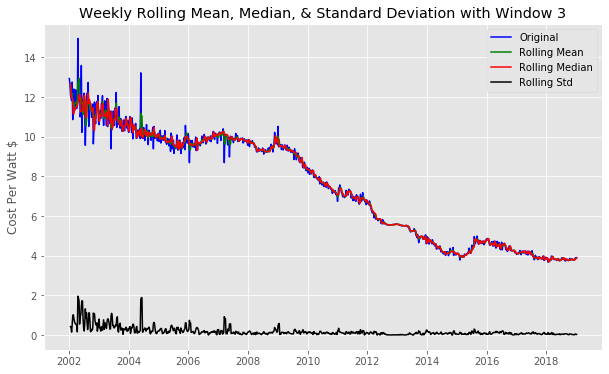

Results of Dickey-Fuller Test:
Test Statistic                  -1.323589
p-value                          0.618312
#Lags Used                      21.000000
Number of Observations Used    866.000000
Critical Value (1%)             -3.437924
Critical Value (5%)             -2.864883
Critical Value (10%)            -2.568550
dtype: float64


In [123]:
rolling_plot(y)
plt.show()
test_stationarity(y)

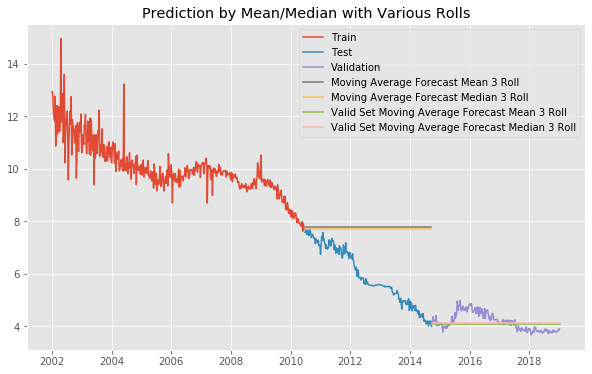

RMS for train test mean =                 2.12594296336556
RMS for train test median =               2.0626800767688382
RMS for valid and vali train mean =       0.33545171363780213
RMS for valid and vali train median =     0.33315423015688783


In [130]:
train = y[:442]
test = y[442:664]
vali_train = y[:664]
vali = y[664:]

y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['cost_per_watt'].rolling(3).mean().iloc[-1]
y_hat_avg['moving_avg_forecastmed'] = train['cost_per_watt'].rolling(3).median().iloc[-1]
y_hat_avgv = vali.copy()
y_hat_avgv['moving_avg_forecast'] = vali_train['cost_per_watt'].rolling(3).mean().iloc[-1]
y_hat_avgv['moving_avg_forecastmed'] = vali_train['cost_per_watt'].rolling(3).median().iloc[-1]

plt.figure(figsize=(10,6))
plt.title('Prediction by Mean/Median with Various Rolls')
plt.plot(train['cost_per_watt'], label='Train')
plt.plot(test['cost_per_watt'], label='Test')
plt.plot(vali['cost_per_watt'], label='Validation')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast Mean 3 Roll')
plt.plot(y_hat_avg['moving_avg_forecastmed'], label='Moving Average Forecast Median 3 Roll')
plt.plot(y_hat_avgv['moving_avg_forecast'], label='Valid Set Moving Average Forecast Mean 3 Roll')
plt.plot(y_hat_avgv['moving_avg_forecastmed'], label='Valid Set Moving Average Forecast Median 3 Roll')

plt.legend(loc='best')
plt.show()

rms = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecast))
rmsm = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecastmed))
print('RMS for train test mean =                ' , rms)
print('RMS for train test median =              ' , rmsm)
rmsv = sqrt(mean_squared_error(vali.cost_per_watt, y_hat_avgv.moving_avg_forecast))
rmsvm = sqrt(mean_squared_error(vali.cost_per_watt, y_hat_avgv.moving_avg_forecastmed))
print('RMS for valid and vali train mean =      ' , rmsv)
print('RMS for valid and vali train median =    ' , rmsvm)

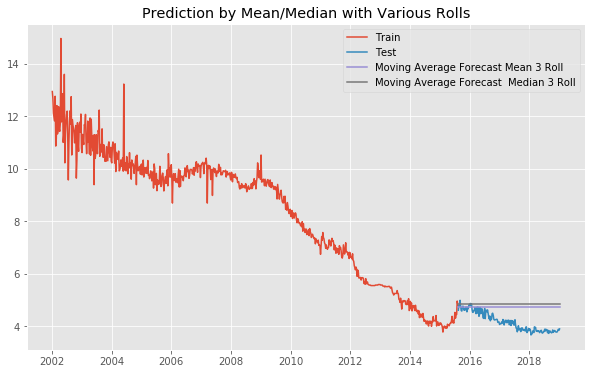

RMS of mean=  0.6740504950763149
RMS of median=  0.7463725009084672


In [134]:
train = y[:710]
test = y[710:]

y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['cost_per_watt'].rolling(3).mean().iloc[-1]
y_hat_avg['moving_avg_forecastmed'] = train['cost_per_watt'].rolling(3).median().iloc[-1]

plt.figure(figsize=(10,6))
plt.title('Prediction by Mean/Median with Various Rolls')
plt.plot(train['cost_per_watt'], label='Train')
plt.plot(test['cost_per_watt'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast Mean 3 Roll')
#plt.plot(y_hat_avg['moving_avg_forecastroll52'], label='Moving Average Forecast Mean 52 Roll')
plt.plot(y_hat_avg['moving_avg_forecastmed'], label='Moving Average Forecast  Median 3 Roll')
#plt.plot(y_hat_avg['moving_avg_forecastmed52'], label='Moving Average Forecast  Median 52 Roll')
plt.legend(loc='best')
plt.show()


rms_mean = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecast))
rms_med = sqrt(mean_squared_error(test.cost_per_watt, y_hat_avg.moving_avg_forecastmed))
print('RMS of mean= ' , rms_mean)
print('RMS of median= ' , rms_med)

ADF p-value: 0.00
Achieved stationarity! Reject ADF H0.


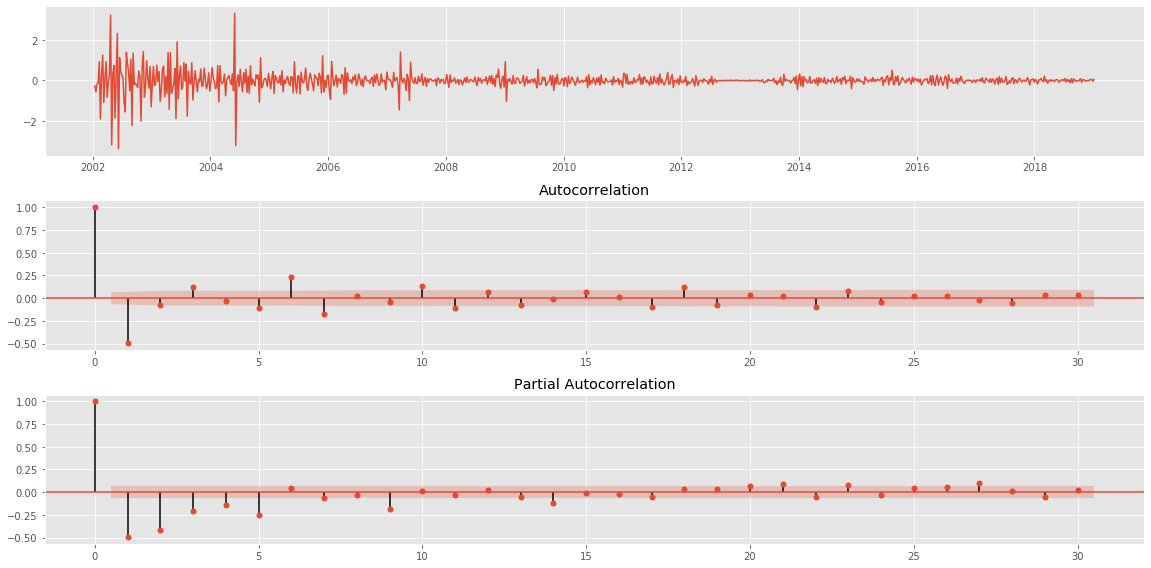

In [273]:
weekly_differences = get_differences(y)
wdn = np.array(weekly_differences.dropna())

In [275]:
wdn = weekly_differences[1:]

In [326]:
solar_model.fittedvalues

installation_date
2002-01-27    12.560665
2002-02-03    12.245870
2002-02-10    11.930596
2002-02-17    12.108678
2002-02-24    11.748754
                ...    
2018-12-09     3.785496
2018-12-16     3.784367
2018-12-23     3.805188
2018-12-30     3.838181
2019-01-06     3.862192
Length: 885, dtype: float64

In [344]:
%autoreload

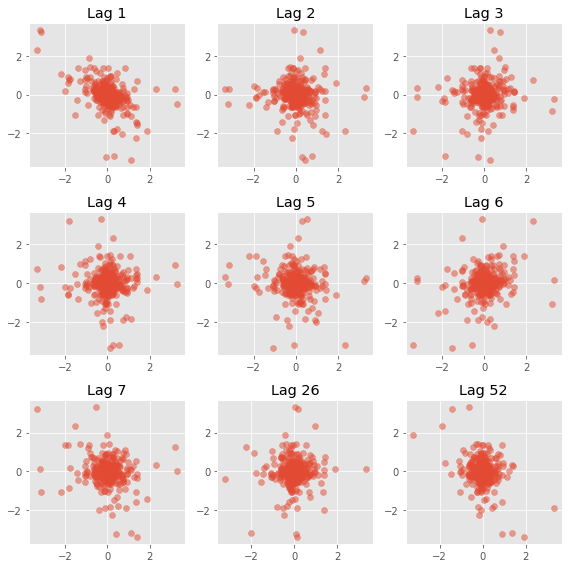

In [345]:
plot_ac_scat(weekly_differences)

In [324]:
lag_cost

,y,Lag1,Lag2,Lag3
,cost_per_watt,cost_per_watt,cost_per_watt,cost_per_watt
installation_date,,,,
2002-01-27,11.950,12.110,12.670,12.935
2002-02-03,11.820,11.950,12.110,12.670
2002-02-10,12.755,11.820,11.950,12.110
2002-02-17,10.860,12.755,11.820,11.950
2002-02-24,11.150,10.860,12.755,11.820
...,...,...,...,...
2018-12-09,3.790,3.780,3.780,3.790
2018-12-16,3.850,3.790,3.780,3.780


In [138]:
auto_arima(wd[1:])

ARIMA(maxiter=50, method='lbfgs', order=(4, 0, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [85]:
mod = ARIMA(weekly_differences, order=(2, 0, 4))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:          cost_per_watt   No. Observations:                  888
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -263.866
Date:                Mon, 16 Mar 2020   AIC                            543.731
Time:                        19:03:46   BIC                            582.043
Sample:                    01-06-2002   HQIC                           558.376
                         - 01-06-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0098      0.002     -4.214      0.000      -0.014      -0.005
ar.L1         -0.9428      0.058    -16.331      0.000      -1.056      -0.830
ar.L2         -0.8386      0.046    -18.219      0.0

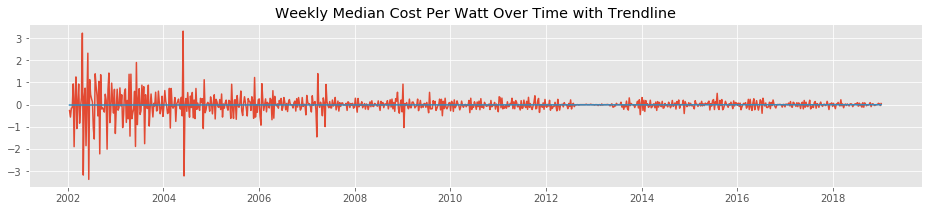

In [112]:
linear_model ,linear_trend = linear_model_trend(weekly_differences_n)

In [88]:
lm_residual_model = ARIMA(
    lm_residuals, order=( 2, 0, 4)).fit()

NameError: name 'lm_residuals' is not defined

In [ ]:
fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(lm_residual_model.resid.index,
            lm_residual_model.resid)
plot_acf_and_pacf(lm_residual_model.resid, axs[1:])
plt.tight_layout()

In [ ]:
arima_preds = lm_residual_model.predict(ywn.index.max(), pd.to_datetime('2019-01-06').tz_localize('UTC'), dynamic=True)

In [ ]:
arima_preds

In [ ]:
X = add_constant(np.arange(1, len(syw) + 1))
y = syw
rf = RandomForestRegressor(oob_score=True,n_jobs=-1)
rf.fit(X,y)

print('OOB Score: {}'.format(rf.oob_score_))
print('r2 score on test: {}'.format(rf.score(X,y)))

rf_predict = rf.predict(X)
mse = mean_squared_error(y,rf_predict)

print('MSE: {}'.format(mse))

In [ ]:
y_hat_avg = weekly_differences.copy()
fit1 = ARIMA(df['cost_per_watt'], order=(2, 0, 4)).fit()
y_hat_avg['ARIMA'] = fit1.predict(start="2019-1-6", end="2020-1-6", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(df['cost_per_watt'], label='Cost Per Watt')
plt.plot(y_hat_avg['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()
model_type = 'ARIMA'
print('RMS Score:',  rms_score(df, model_type))

get p and q by reviewing AC and PAC - look at at which value the line drops below y-axis 0

In [ ]:
w_diff = weekly_differences[1:]

In [ ]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

lags = [1,2,3,4,5,6,7,8,52]

for i, ax in zip(lags,axs.flatten()):
    series, lagged = series_and_lagged(w_diff, lag=i)
    autocorr = compute_autocorrelation(w_diff, lag=i)
    ax.scatter(series, lagged, alpha=0.5)
    ax.set_title("Lag {0} AC: {1:2.2f}".format(i, autocorr))
    
plt.tight_layout()

In [ ]:
def fit_ar_model(series, order):
    # ARIMA is a more general model, which we are going to build up
    # in pieces.
    model = ARIMA(series, order=(order, 0, 0))
    return model.fit()

In [ ]:
for coef in ar_coefs:
    ar_series = auto_regressive_process(size=250, coefs=coef)
    ar_model = fit_ar_model(ar_series.values, order=(len(coef)))
    print("True Coefficients: {0: <26} Estimated Coefficients: {1: <26}".format(
            str(format_list_of_floats(coef)),
            str(format_list_of_floats(ar_model.params[1:]))))

In [ ]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [ ]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coef))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))


In [ ]:
mod = ARIMA(weekly_differences, order=(2, 0, 4))
res = ARIMA(weekly_differences, order=(2, 0, 4)).fit()

print("ARIMA(2, 0, 4) coefficients from model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    res.params[0], 
        format_list_of_floats(list(res.params[1:]))))

In [ ]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(weekly_differences.index, weekly_differences)
ax[0].set_title("First Differences of Solar Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(weekly_differences), list(res.params)[1:])
    simulated_data.index = weekly_differences.index
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Solar Model Fit")
    
plt.tight_layout()


In [ ]:
syw

In [ ]:
statsmodels.tsa.arima_model.ARIMAResults.plot_predict

In [ ]:
res.predict()

In [ ]:
res = ARIMA(weekly_differences, order=(2, 0, 4)).fit()

In [ ]:
#variance/ covariance matrix
ARIMAResults.cov_params(res)

In [ ]:
ARIMAResults.forecast(res, steps = 52,).plot()

In [ ]:
ARIMAResults.summary()

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot()

In [ ]:
ARIMAResults.predict(res,start = '2018-12-09', end= '2020', dynamic=True).plot()

In [ ]:
ARIMAResults.info_criteria(res, 'aic')
ARIMAResults.info_criteria(res, 'bic')

In [ ]:
ARIMAResults.predict(w_diff.cost_per_watt)

In [ ]:
res.arparams

In [ ]:
#standard erorrs
res.bse

In [ ]:
res.llf

In [ ]:
res.llf_obs

In [ ]:
res.maparams

In [ ]:
res.maroots

In [ ]:
res.pvalues

In [ ]:
res.resid

In [ ]:
w_diff.plot()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(res.predict(), label='Full Predictions')
plt.plot(w_diff, label='Weekly_Differences')
plt.plot(pred, label = 'Future Predictions')
plt.plot(preds, label= 'Predictions from 2016 -')
#plt.plot(syw, label = 'Full Data')
plt.legend(loc='best')
plt.show()


In [ ]:
plt.figure(figsize=(16,8))
plt.plot(res.predict(end = '2020'), label='Full Predictions')
plt.plot(w_diff, label='Weekly_Differences')
#plt.plot(pred, label = 'Future Predictions')
plt.plot(preds, label= 'Predictions from 2016 - 2020')
plt.legend(loc='best')
plt.show()


In [ ]:
mod.fit()

In [ ]:
mod.fit()

In [ ]:
w_diff.loc[w_diff.index.year > 2013]

In [ ]:
pred = res.predict(start = '2018-12-09', end= '2020')

In [ ]:
pred

In [ ]:
preds = res.predict(start= '2016-01-03', end= '2020')

In [ ]:
preds

In [ ]:
plt.plot(res.predict(end = '2020'), label='Full Predictions')
plt.plot(w_diff, label='Weekly_Differences')
#plt.plot(pred, label = 'Future Predictions')
plt.plot(preds, label= 'Predictions from 2016 - 2020')

In [ ]:
all_year_preds = res.predict(end = '2020')
last_four_preds = res.predict(start= '2016-01-03', end= '2020')

In [ ]:
w_diff

In [ ]:
res.plot_diagnostics()

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    #mins = np.amin(np.hstack([forecast[:,None], 
                              #actual[:,None]]), axis=1)
    #maxs = np.amax(np.hstack([forecast[:,None], 
                              #actual[:,None]]), axis=1)
    #minmax = 1 - np.mean(mins/maxs)             # minmax
    #acf1 = acf(fc-test)[1]                      # ACF1
    #return({'Mean Absolute Percentage Error':mape, 'Mean Error':me, 'Mean Absolute Error ': mae, 
            #'Mean Percentage Error': mpe, 'Root Mean Squared Error ':rmse, #'Lag 1 Autocorrelation of Error':acf1, 
            #'Correlation between the Actual and the Forecast':corr}) #'Min-Max Error ':minmax})
    print('Mean Absolute Percentage Error:  ', mape, '\nMean Error:                      ',me, '\nMean Absolute Error :            ', mae, 
            '\nMean Percentage Error:           ', mpe, '\nRoot Mean Squared Error :        ',rmse, #'Lag 1 Autocorrelation of Error':acf1, 
            '\nCorrelation between the \nActual and the Forecast:         ',corr) #'Min-Max Error ':minmax})

In [ ]:
forecast_accuracy(forecastt, actual)

In [ ]:
actual = w_diff.cost_per_watt

In [ ]:
forecast = pd.DataFrame(all_year_preds[1:])
forecast = forecast[0]
forecastt =  forecast.loc[forecast.index < '2019-01-07']

In [ ]:
np.mean(np.abs(w_diff))

In [ ]:
res.predict(1,)

In [ ]:
X

In [ ]:
from sklearn.model_selection import TimeSeriesSplit 

In [ ]:
week_differences

In [ ]:
s_lagg

In [ ]:
weekly_differences = s_lagg.diff(periods=1)

In [ ]:
weekly_differences.dropna(inplace=True)

In [ ]:
weekly_differences.dropna().drop(['y'], axis=1)

In [ ]:
weekly_differences.y.dropna()

In [ ]:
X_train

In [ ]:
y.dropna

In [ ]:
test_index = int(len(X)*(1-.2))

In [ ]:
y_train

In [ ]:
weekly_differences

In [ ]:
y = weekly_differences.y.dropna()
X = weekly_differences.dropna().drop(['y'], axis=1)

In [ ]:
# reserve 20% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
coefs

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
timeseries_train_test_split(X,y, test)

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False, scale=1.96):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_squared_error")
        #mae = cv.mean() * (-1)
        deviation = np.sqrt(cv.std())
        
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    print("Mean absolute percentage error", error)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    

In [ ]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    


In [ ]:
rf = RandomForestRegressor(oob_score=True,n_jobs=-1)
rf.fit(X,y)

print('OOB Score: {}'.format(rf.oob_score_))
print('r2 score on test: {}'.format(rf.score(X,y)))

rf_predict = rf.predict(X)
mse = mean_squared_error(y,rf_predict)

print('MSE: {}'.format(mse))

In [ ]:
thePipe = Pipeline([('RFR', RandomForestRegressor())])

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

In [ ]:
LinearRegression()

In [ ]:
rf

In [ ]:
py

In [ ]:
# yw = resamp_lag_ols(df)
# lagg_cost = create_lag(yw)

# ywn = pd.DataFrame(yw.cost_per_watt).dropna()

#Box Jenkins Method
fig, axs = plt.subplots(2, figsize=(16, 6))
plot_acf_and_pacf(ywn, axs)
plt.tight_layout()

weekly_differences = ywn.diff(periods=1)

fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(weekly_differences.index, weekly_differences)
# The first entry in the differenced series is NaN.
plot_acf_and_pacf(weekly_differences[1:], axs[1:])
plt.tight_layout()
test = sm.tsa.stattools.adfuller(weekly_differences[1:])
print("ADF p-value: {0:2.2f}".format(test[1]))

X = add_constant(np.arange(1, len(ywn) + 1))
y = ywn

linear_trend = sm.OLS(y, X).fit().predict(X)

fig, ax = plt.subplots(1, figsize=(16, 3))

ax.plot(ywn.index, ywn)
ax.plot(ywn.index, linear_trend)
ax.set_title("Weekly Median Cost Per Watt Over Time with Trendline")

linear_trend

linear_model = sm.OLS(y, X).fit()
linear_trend = linear_model.predict(X)

lm_residuals = pd.Series(ywn.cost_per_watt -linear_trend, index=ywn.index)

lm_residuals

fig, axs = plt.subplots(3, figsize=(16, 8))
# The model predicts zero for the first few datapoints, so the residuals
# are the actual values.
axs[0].plot(lm_residuals.index, lm_residuals)
plot_acf_and_pacf(lm_residuals, axs[1:])
plt.tight_layout()

lm_residual_model = ARIMA(
    lm_residuals, order=( 1, 1, 1)).fit()

fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(lm_residual_model.resid.index,
            lm_residual_model.resid)
plot_acf_and_pacf(lm_residual_model.resid, axs[1:])
plt.tight_layout()

ywn

arima_preds = lm_residual_model.predict(ywn.index.max(), pd.to_datetime('2019-01-06').tz_localize('UTC'), dynamic=True)

# long_df['Week'] = long_df.index.date

arima_preds

X = np.column_stack([ywn,
                     add_constant(np.arange(1, len(ywn) + 1))])

lm_preds = pd.Series(
    linear_model.predict(X),
    index=ywn.index)

lm_preds= lm_preds[arima_preds.index.min():]

In [ ]:
get_differences(df.cost_per_watt)

In [8]:
df

,system_size,total_installed_price,customer_segment,date,adj_installed_price,cost_per_watt
installation_date,,,,,,
1998-01-30,4.251500,17439.0,RES,1998-01-30,27838.84,6.55
1998-04-08,2.331600,30941.0,RES,1998-04-08,49119.27,21.07
1998-04-30,4.181100,17439.0,RES,1998-04-30,27684.65,6.62
1998-07-07,2.282400,24500.0,RES,1998-07-07,38727.26,16.97
1998-07-10,3.113265,17439.0,RES,1998-07-10,27565.91,8.85
...,...,...,...,...,...,...
2018-12-31,5.760000,22000.0,RES,2018-12-31,22590.03,3.92
2018-12-31,4.410000,21610.0,RES,2018-12-31,22189.57,5.03
2018-12-31,8.640000,45958.6,RES,2018-12-31,47191.20,5.46


In [10]:
ndf = pd.DataFrame(df['cost_per_watt'].resample('D').median())
lag_cost = (pd.concat([ndf.shift(i) for i in range(4)], axis=1, keys=['y'] + ['Lag%s' % i for i in range(1, 4)])).dropna()
solar_model = smf.ols('y ~ Lag1 + Lag2 + Lag3', data=lag_cost).fit()
print(solar_model.summary())
print(ndf, lag_cost, solar_model) 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     4842.
Date:                Tue, 17 Mar 2020   Prob (F-statistic):               0.00
Time:                        19:24:51   Log-Likelihood:                -9154.7
No. Observations:                5123   AIC:                         1.832e+04
Df Residuals:                    5119   BIC:                         1.834e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4515      0.057      7.935      0.0

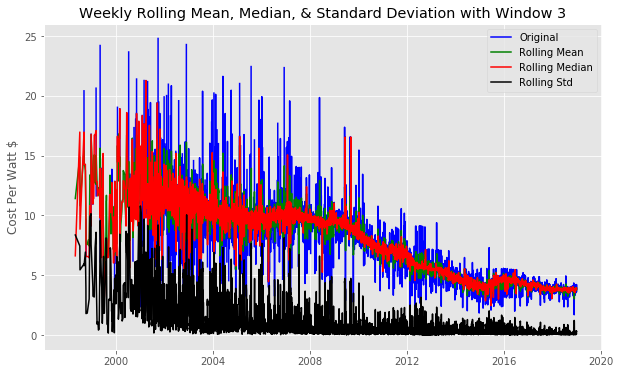

In [11]:
rolling_plot(ndf)

In [14]:
ndfn = ndf.dropna()

In [16]:
test_stationarity(ndfn)

Results of Dickey-Fuller Test:
Test Statistic                   -1.561009
p-value                           0.503144
#Lags Used                       33.000000
Number of Observations Used    6151.000000
Critical Value (1%)              -3.431414
Critical Value (5%)              -2.862010
Critical Value (10%)             -2.567020
dtype: float64


,y,Lag1,Lag2,Lag3
,cost_per_watt,cost_per_watt,cost_per_watt,cost_per_watt
installation_date,,,,
1999-11-04,9.905,11.51,13.86,12.750
2001-02-23,4.270,8.39,11.10,10.525
2001-02-24,17.660,4.27,8.39,11.100
2001-04-26,18.860,10.60,2.94,21.190
2001-04-27,5.090,18.86,10.60,2.940
...,...,...,...,...
2018-12-27,3.790,3.90,3.68,3.900
2018-12-28,3.800,3.79,3.90,3.680


ADF p-value: 0.00
Achieved stationarity! Reject ADF H0.


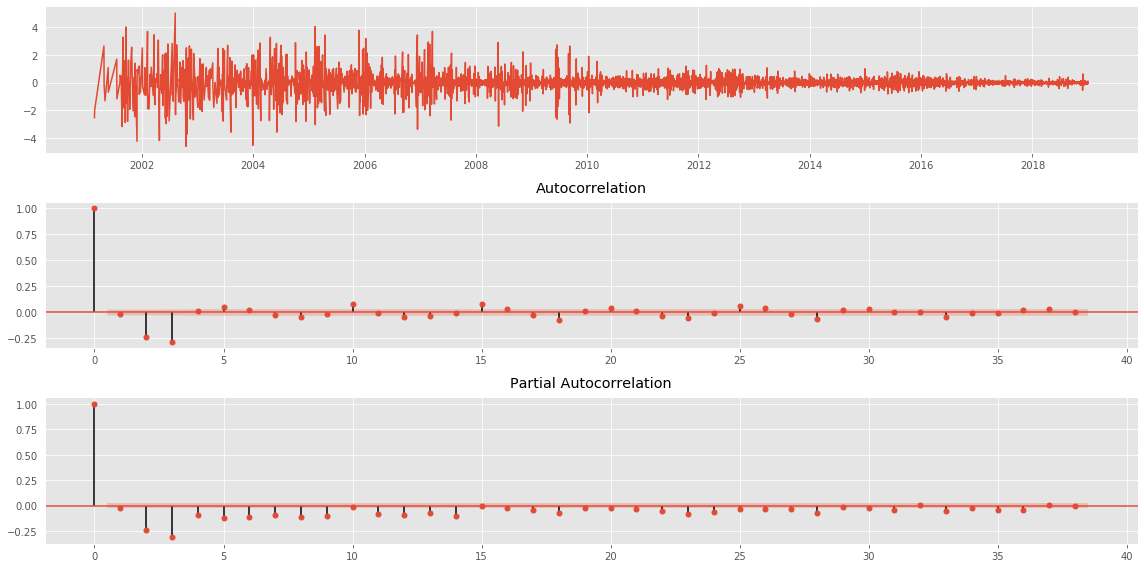

In [121]:
daily_differences = get_differences(solar_model.fittedvalues)

ADF p-value: 0.00
Achieved stationarity! Reject ADF H0.


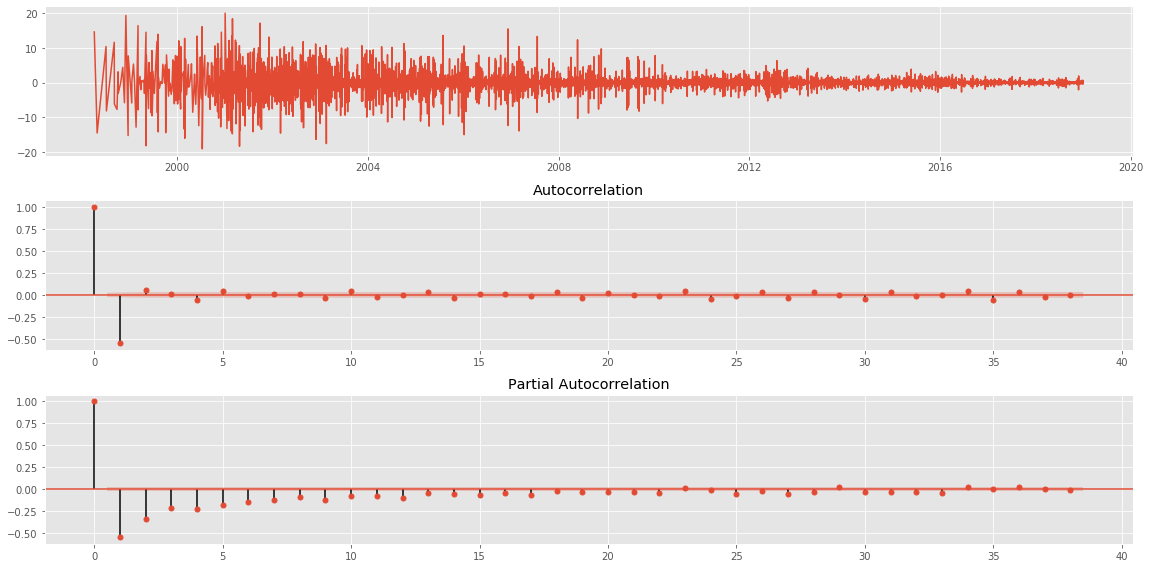

In [20]:
daily_differences = get_differences(ndfn)

In [130]:
%autoreload

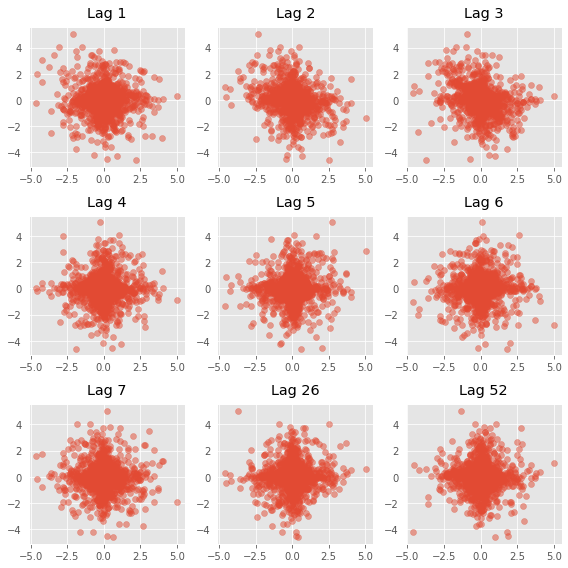

In [122]:
plot_ac_scat(daily_differences)

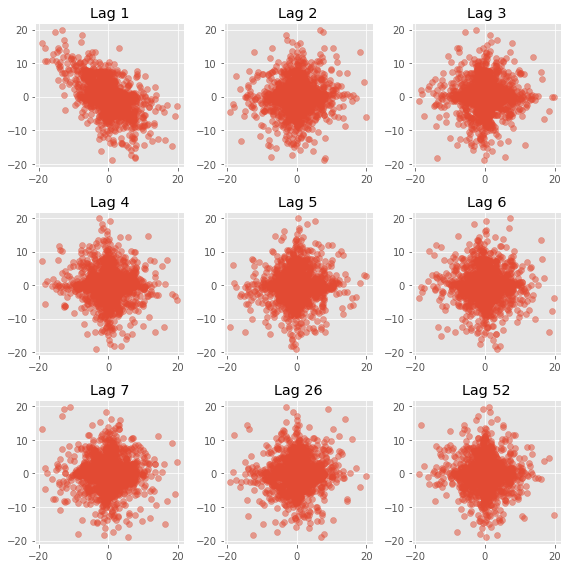

In [26]:
plot_ac_scat(daily_differences)

In [34]:
from src.TSA import * 

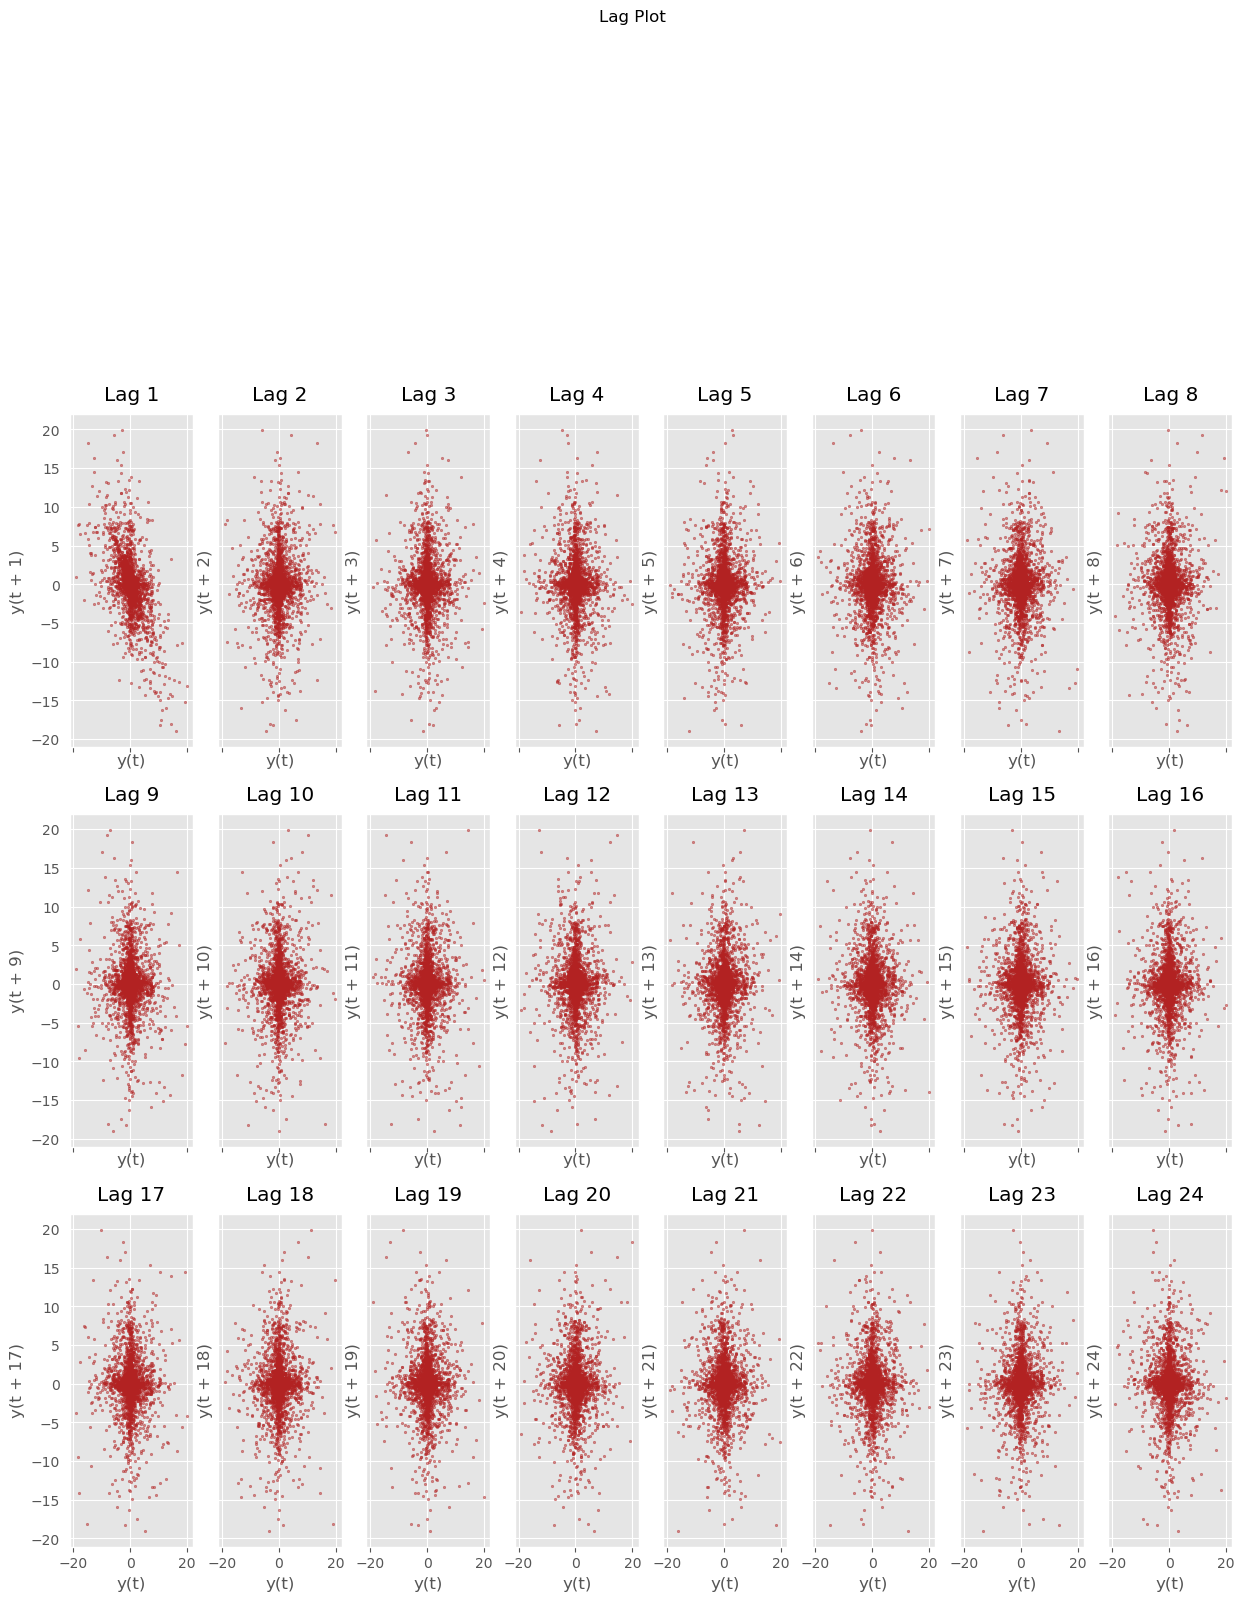

In [39]:
lag_plots(daily_differences)

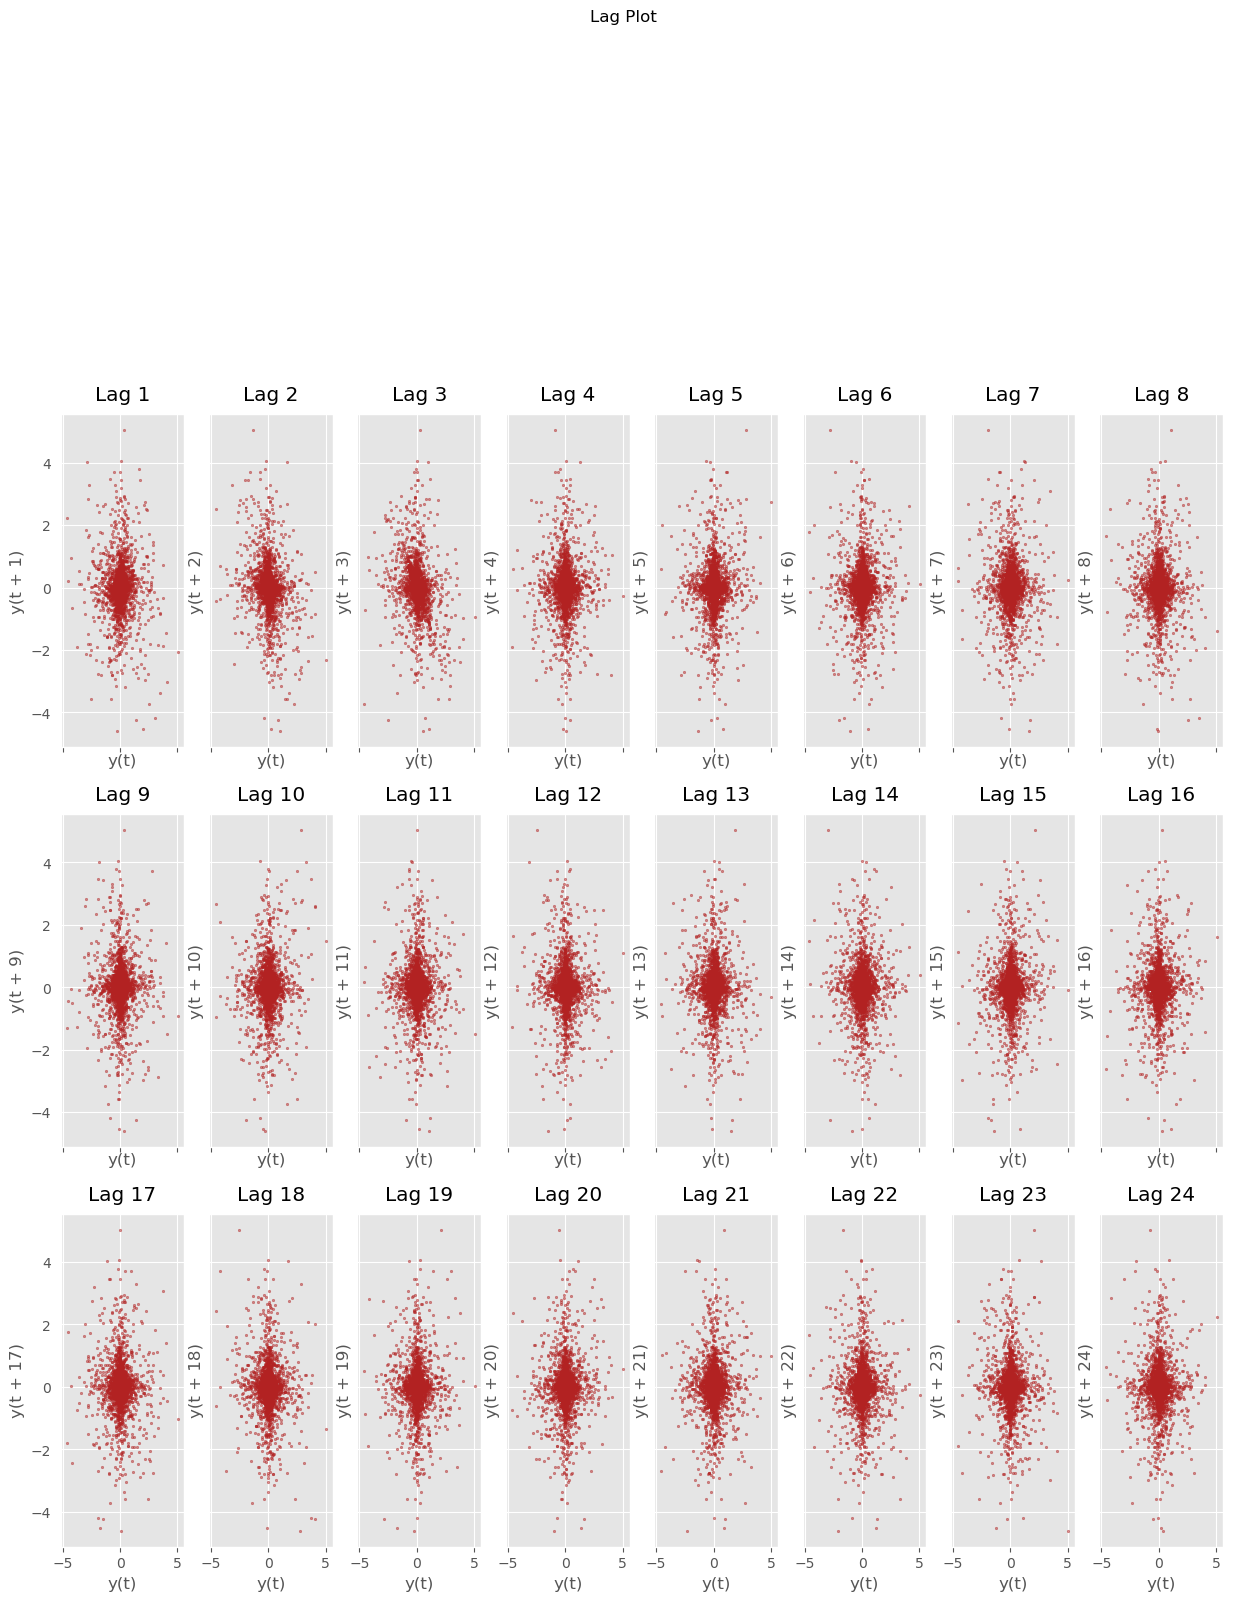

In [131]:
lag_plots(daily_differences)

In [85]:
ywn = pd.DataFrame(ndf.cost_per_watt).dropna()
rollingmedian1 = ywn.rolling(window=1).median()
rollingmedian7 = ywn.rolling(window=7).median()

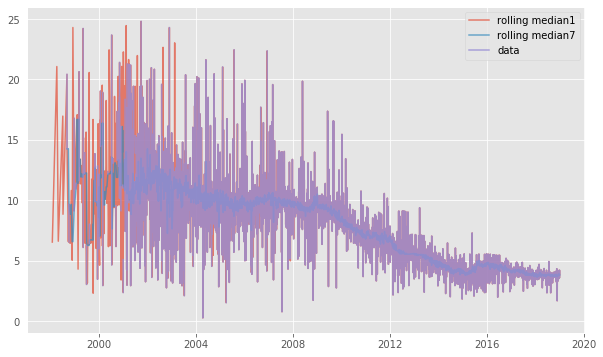

In [105]:
plt.plot(rollingmedian1, alpha=0.7, label='rolling median1')
plt.plot(rollingmedian7, alpha=0.7, label='rolling median7')
plt.plot(ndf, alpha=0.8, label='data')
plt.legend(loc='best')
plt.show()

In [107]:
from statsmodels.tsa.stattools import acf, pacf


In [142]:
lag_acf = acf(daily_differences, nlags=3)
lag_pacf = pacf(daily_differences, nlags=3)

Text(0.5, 1.0, 'Autocorrelation Function')

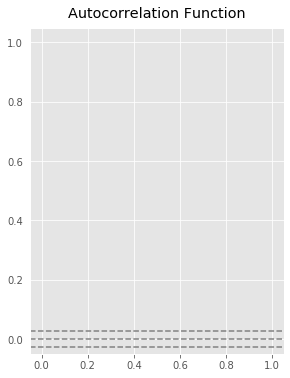

In [143]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(daily_differences)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(daily_differences)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

In [137]:
daily_differences

installation_date
1999-11-04         NaN
2001-02-23   -2.528688
2001-02-24   -1.987841
2001-04-26    2.654745
2001-04-27   -0.093360
                ...   
2018-12-27   -0.106910
2018-12-28   -0.012742
2018-12-29    0.025295
2018-12-30   -0.086635
2018-12-31    0.101845
Length: 5123, dtype: float64

In [120]:
solar_model.fittedvalues

installation_date
1999-11-04    12.437571
2001-02-23     9.908883
2001-02-24     7.921042
2001-04-26    10.575787
2001-04-27    10.482427
                ...    
2018-12-27     4.017759
2018-12-28     4.005016
2018-12-29     4.030311
2018-12-30     3.943676
2018-12-31     4.045521
Length: 5123, dtype: float64

In [144]:
ywnd = pd.DataFrame(daily_differences).dropna()
rollingmediand1 = ywnd.rolling(window=1).median()
rollingmediand7 = ywnd.rolling(window=7).median()

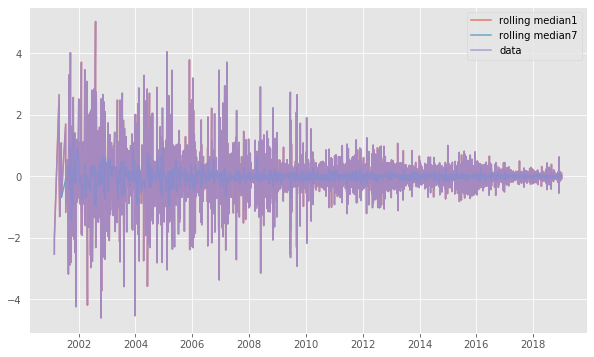

In [146]:
plt.plot(rollingmediand1, alpha=0.7, label='rolling median1')
plt.plot(rollingmediand7, alpha=0.7, label='rolling median7')
plt.plot(ywnd, alpha=0.8, label='data')
plt.legend(loc='best')
plt.show()


In [ ]:
predict=daily_differences.query("time> '20-01-09 00:00' and time<= '2020-01-16 00:00'")[['cost_per_watt']]
predict['cost_1weekago']=daily_differences[['cost_per_watt']].shift(168).query("time> '2020-01-09 00:00' and time<= '2020-01-16 00:00'")
predict['cost_3weeksago']=daily_differences[['cost_per_watt']].shift(168).query("time> '2020-01-09 00:00' and time<= '2020-01-16 00:00'")


predict[['cost_per_watt', 'cost_1weekago']].plot(figsize=(20, 10))
predict[['cost_per_watt', 'cost_3weeksago']].plot(figsize=(20, 10))
precision(predict,'cost_1weekago','cost_per_watt')
precision(predict,'cost_3weeksago','cost_per_watt')


ADF p-value: 0.00
Achieved stationarity! Reject ADF H0.


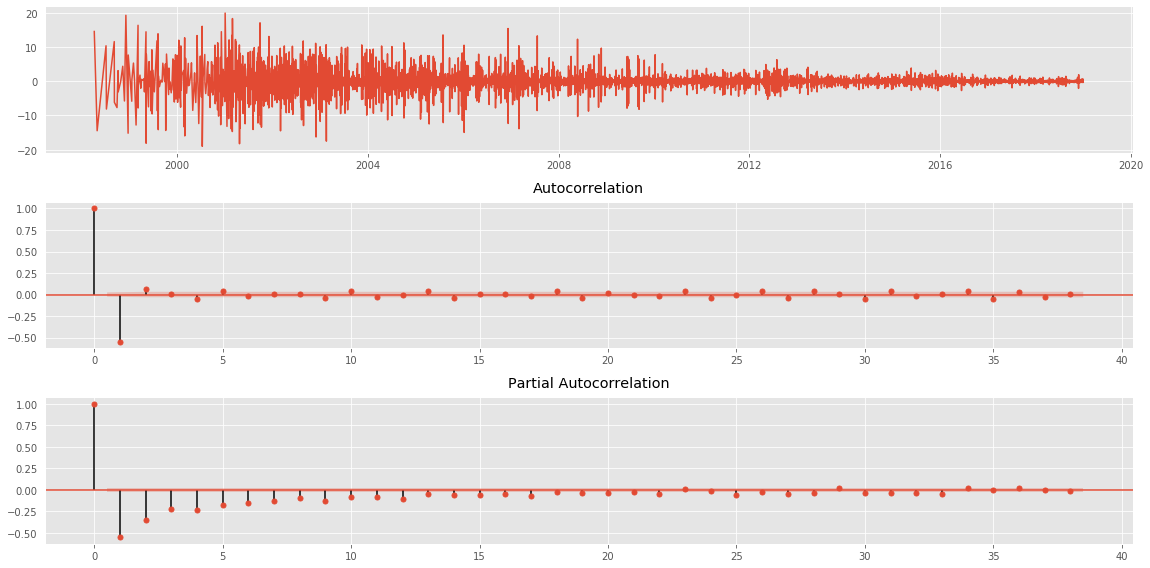

In [278]:
daily_d = pd.DataFrame(get_differences(ndfn))

In [292]:
daily = daily_d.resample('D').median()

In [196]:
predict = pd.DataFrame(daily_d.loc[daily_d.index.year>2017])

In [297]:
predict['cost_1dayago'] = daily_d['cost_per_watt'].shift(1)
predict['cost_1weekago'] = daily_d['cost_per_watt'].shift(7)

In [298]:
predict

,cost_per_watt,cost_1dayago,cost_1weekago
installation_date,,,
2018-01-01,0.070,0.030,-0.340
2018-01-02,0.290,0.070,0.885
2018-01-03,-0.180,0.290,-0.175
2018-01-04,0.065,-0.180,0.090
2018-01-05,-0.025,0.065,0.040
...,...,...,...
2018-12-27,-0.110,0.220,0.040
2018-12-28,0.010,-0.110,0.010
2018-12-29,-0.210,0.010,-0.375


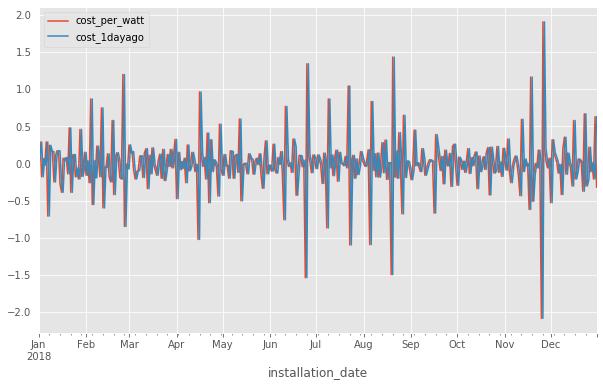

In [201]:
predict[['cost_per_watt', 'cost_1dayago']].plot()

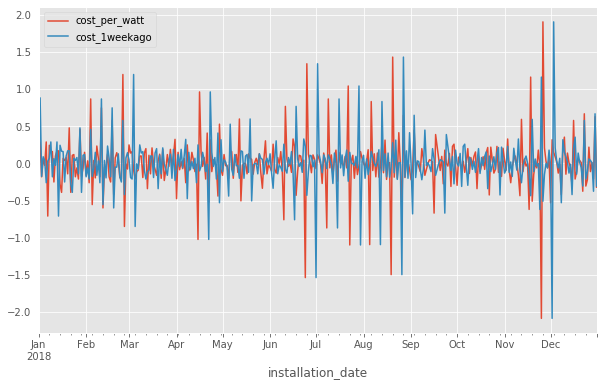

In [202]:
predict[['cost_per_watt', 'cost_1weekago']].plot()

In [207]:
precision(predict,'cost_1dayago','cost_per_watt')
precision(predict,'cost_1weekago','cost_per_watt')

cost_1dayago [Rsquared: -1.98 MAE: 0.38 MSE: 0.38 RMSE: 0.62 MAPE: inf MAPE_adjust: 19.58 sMAPE: inf ]
cost_1weekago [Rsquared: -0.92 MAE: 0.3 MSE: 0.24 RMSE: 0.49 MAPE: inf MAPE_adjust: 7.93 sMAPE: inf ]


In [ ]:
X = add_constant(np.arange(1, len(daily_d) + 1))
y = daily_d

linear_trend = sm.OLS(y, X).fit().predict(X)

fig, ax = plt.subplots(1, figsize=(16, 3))

ax.plot(ywn.index, ywn)
ax.plot(ywn.index, linear_trend)
ax.set_title("Weekly Median Cost Per Watt Over Time with Trendline")

linear_trend

linear_model = sm.OLS(y, X).fit()
linear_trend = linear_model.predict(X)

lm_residuals = pd.Series(ywn.cost_per_watt -linear_trend, index=ywn.index)

lm_residuals

fig, axs = plt.subplots(3, figsize=(16, 8))
# The model predicts zero for the first few datapoints, so the residuals
# are the actual values.
axs[0].plot(lm_residuals.index, lm_residuals)
plot_acf_and_pacf(lm_residuals, axs[1:])
plt.tight_layout()

lm_residual_model = ARIMA(
    lm_residuals, order=( 1, 1, 1)).fit()

fig, axs = plt.subplots(3, figsize=(16, 8))

axs[0].plot(lm_residual_model.resid.index,
            lm_residual_model.resid)
plot_acf_and_pacf(lm_residual_model.resid, axs[1:])
plt.tight_layout()

ywn

arima_preds = lm_residual_model.predict(ywn.index.max(), pd.to_datetime('2019-01-06').tz_localize('UTC'), dynamic=True)

# long_df['Week'] = long_df.index.date

arima_preds

X = np.column_stack([ywn,
                     add_constant(np.arange(1, len(ywn) + 1))])

lm_preds = pd.Series(
    linear_model.predict(X),
    index=ywn.index)

lm_preds= lm_preds[arima_preds.index.min():]